In [6]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import pymc3 as pm
import pandas as pd
import sys
import arviz

sys.path.append("../../codes/")
import utils

In [2]:
# Plot configs
%matplotlib inline
%config InlineBackend.figure_format = "retina"
plt.style.use("fivethirtyeight")

# Overview

$\newcommand{\rhat}{\widehat R}$
In this notebook we will stress test the sensitivity of each variant of $\rhat$ in the `toymodel` notebook. To explore this, we will look at the corresponding $\rhat$ values as the variance of one of the chains is steadily increased.

# Sample data

First, let's generate some sample data and run our sampler on it to create our base case:

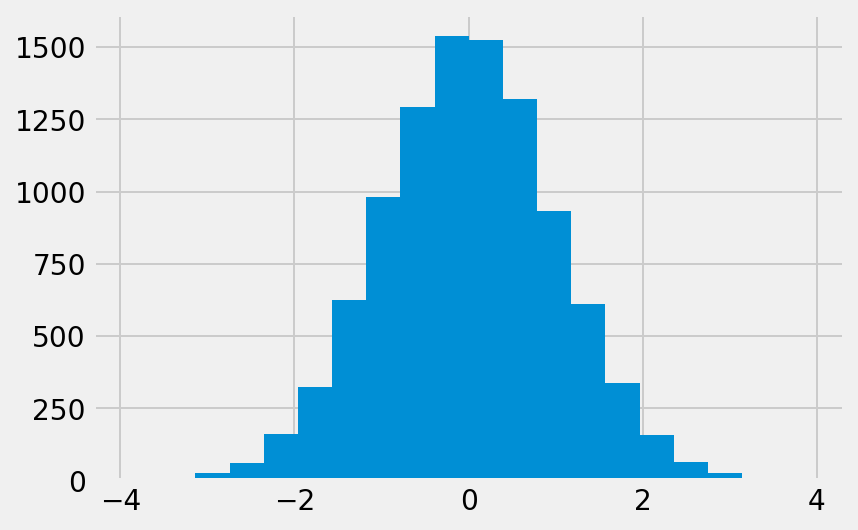

In [3]:
seed = 42
np.random.seed(seed)
data = np.random.normal(size=10_000)
plt.hist(data, bins=20)
plt.show()

In [4]:
# Base model
params = ["mu"] # Parameters to fit for
with pm.Model() as model:
    mu = pm.Normal(params[0], 0, 1)
    y_obs = pm.Normal("y_obs", mu=mu, sigma=1.0, observed=data)
    trace = pm.sample(1_000, chains=4, tune=1_000, random_seed=seed)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu]
Sampling 4 chains: 100%|██████████| 8000/8000 [00:01<00:00, 4175.92draws/s]


The associated graphical model is shown below:

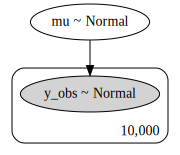

In [18]:
pm.model_to_graphviz(model)

# Simulated convergence failure

Now, to simulate runs where the variance of one of the chains increases, we run a suite of identical models `model_fake` where the variance of each chain is steadily dialed up from 1 to $\sqrt 2$. A single chain from each run is then spliced into the orignal model:

In [6]:
# Turn off output from `pymc3`
import logging 
logger = logging.getLogger('pymc3')
logger.setLevel(logging.ERROR)

traces_fake = [] # each entry will hold a fake chain combined with the original
sigmas = np.linspace(1.0, np.sqrt(2), 10)
for sigma in sigmas:
    # extract trace array from pymc3's MultiTrace object
    trace_original = np.array(trace.get_values(params[0], combine=False)) 
    print(f"Working on var={sigma**2}")
    # increased variance model
    with pm.Model() as model_fake:
        mu = pm.Normal(params[0], 0, 1)
        y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=data)
        trace_fake = pm.sample(1_000, chains=2, tune=1_000, random_seed=seed,
                               compute_convergence_checks=False,
                               progressbar=False, cores=1)
    
    # convert fake trace object to ndarray
    chain_fake = np.array(trace_fake.get_values(params[0], combine=False))[0, :]
    # replace first chain of original trace array with the fake chain
    trace_original[0, :] = chain_fake
    # update list of fake traces
    traces_fake.append(trace_original)
    
trace_fake = np.array(traces_fake)

Working on var=1.0
Working on var=1.0941656419502408
Working on var=1.1925676511906995
Working on var=1.2952060277213755
Working on var=1.4020807715422694
Working on var=1.5131918826533803
Working on var=1.6285393610547088
Working on var=1.7481232067462553
Working on var=1.8719434197280194
Working on var=2.0000000000000004


In [7]:
# Save modified models to disk for quick access
np.save("data/models.npy", traces_fake)

# Results

With our suite of modified models, we can now observe what happens to each version of $\rhat$:

Model 0
----------
var = 1.0
1.0006569404164358
1.000730485378461
1.0007330315121938
1.0006108108119312


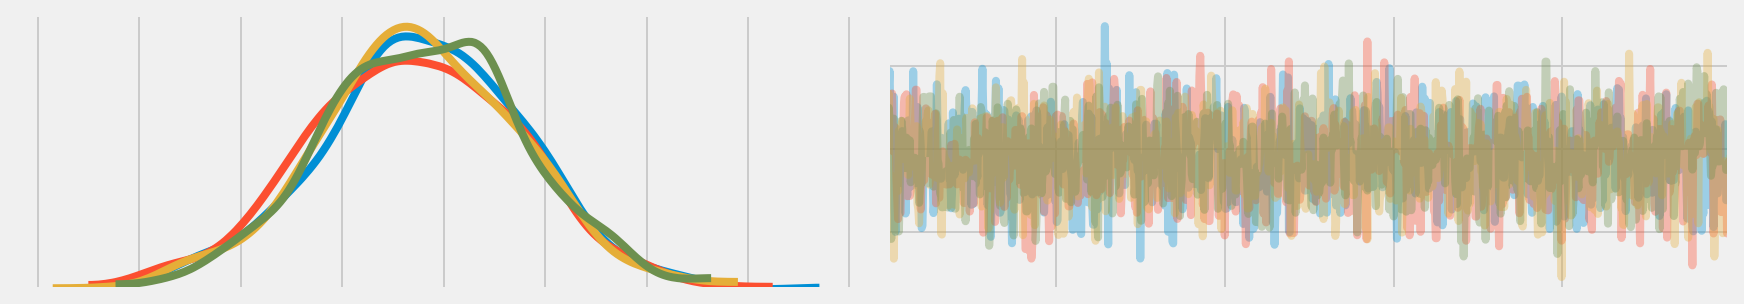

Model 1
----------
var = 1.0941656419502408
1.0002602982216264
1.0001809585701802
1.0001548183967113
1.0010801651714387


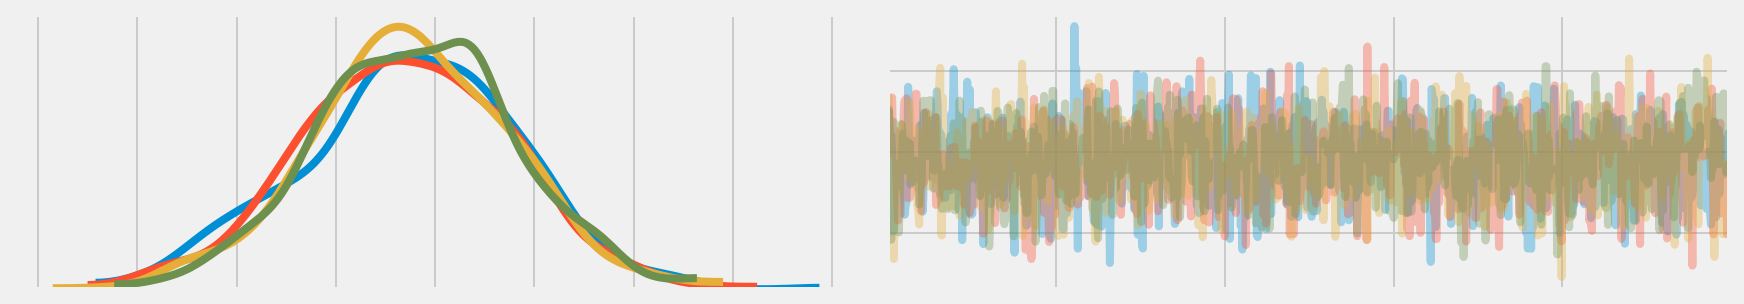

Model 2
----------
var = 1.1925676511906995
1.0003603619355415
1.0048958650061797
1.0047969680478923
1.0008492820118378


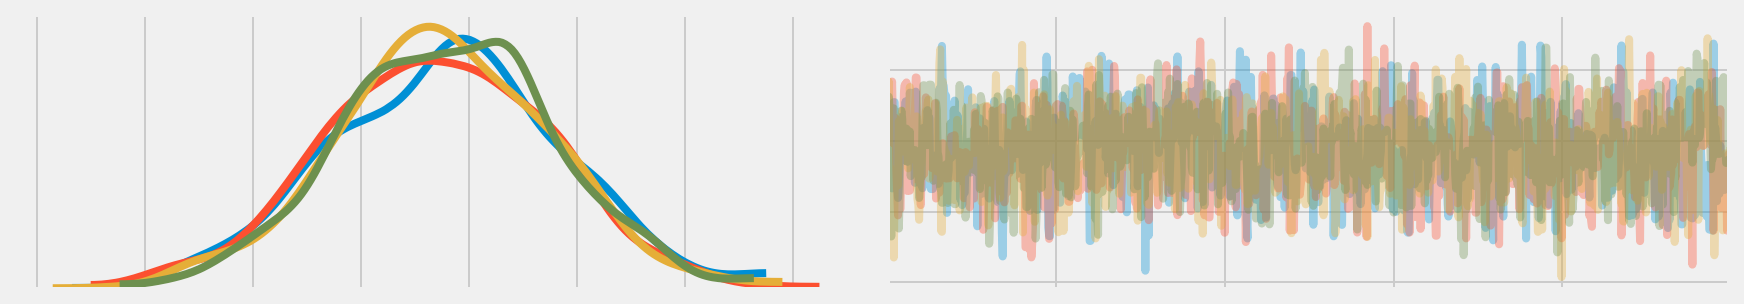

Model 3
----------
var = 1.2952060277213755
1.0002258338628185
1.0001604617316162
1.000185639136151
1.0021581935196546


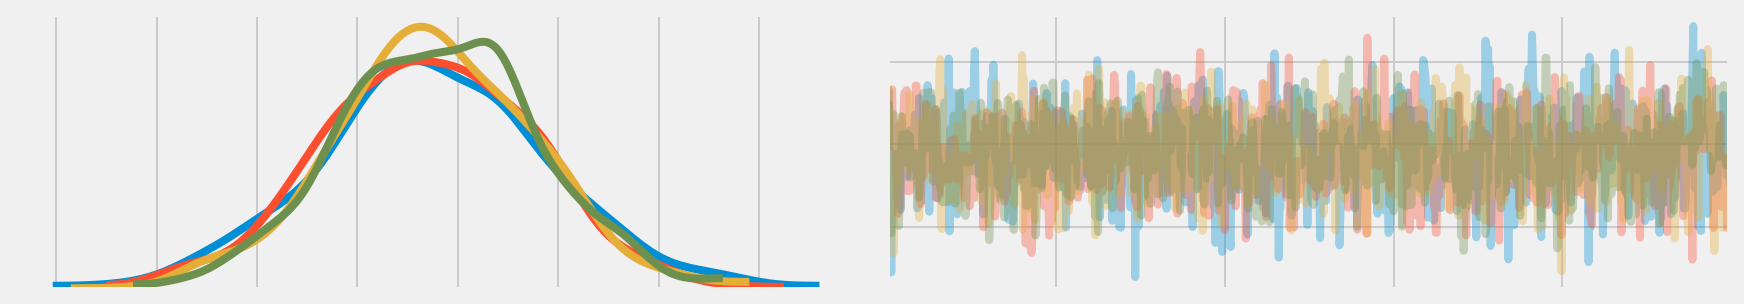

Model 4
----------
var = 1.4020807715422694
1.0010032141691454
1.0007953249827415
1.0008422185414199
1.0067506656886864


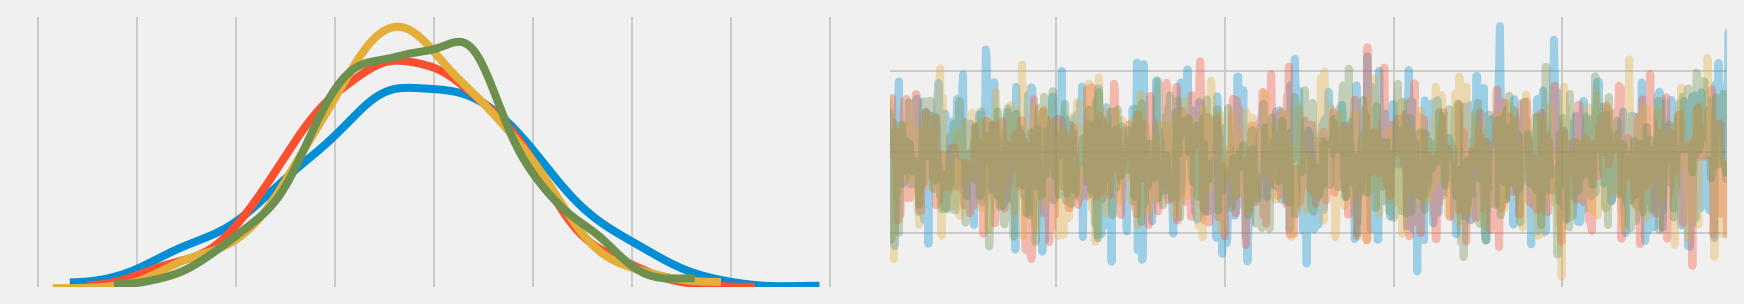

Model 5
----------
var = 1.5131918826533803
1.0001804838633732
1.0000829310105517
1.0000718593417064
1.008262699041156


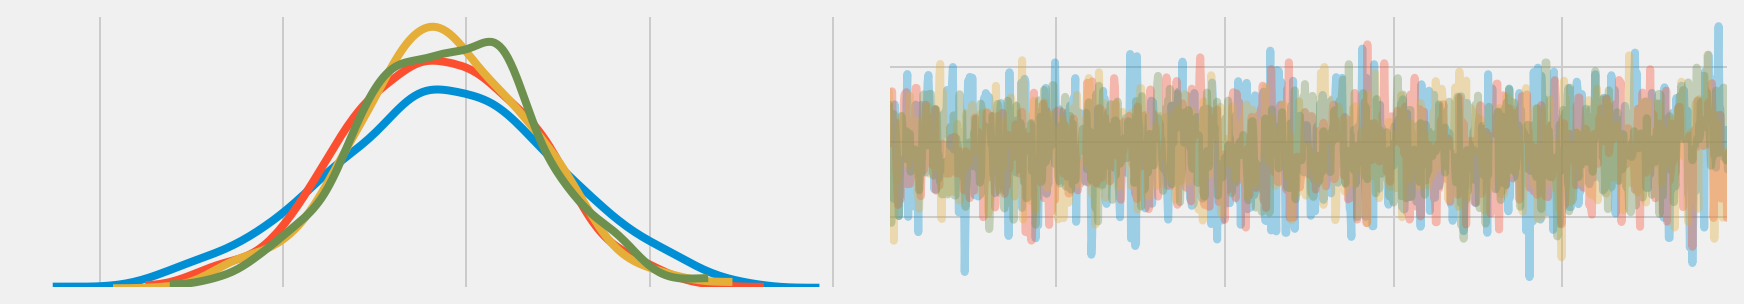

Model 6
----------
var = 1.6285393610547088
1.0001957028023516
1.0015841494730957
1.0016156012016426
1.0070834241509234


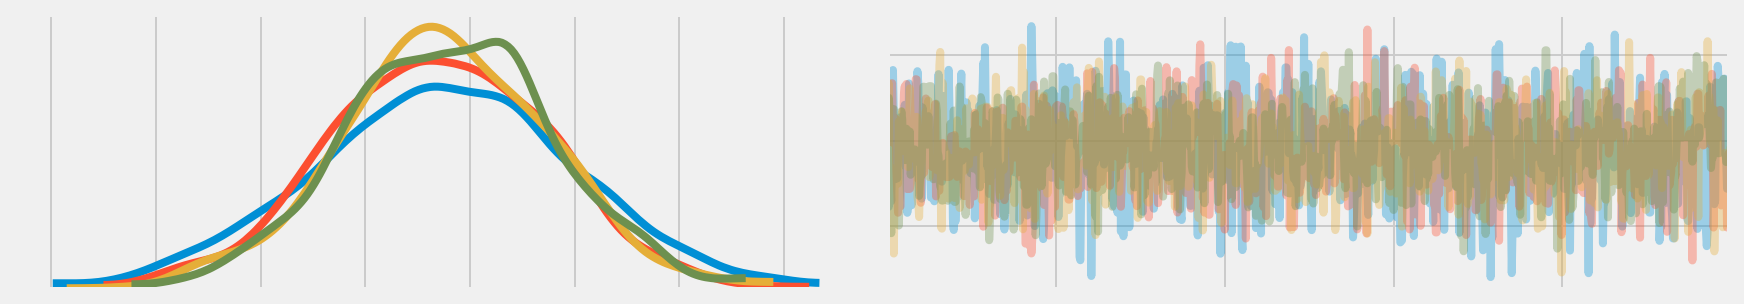

Model 7
----------
var = 1.7481232067462553
1.0001772436902168
1.0002994222804815
1.0003345022322854
1.0147263565729066


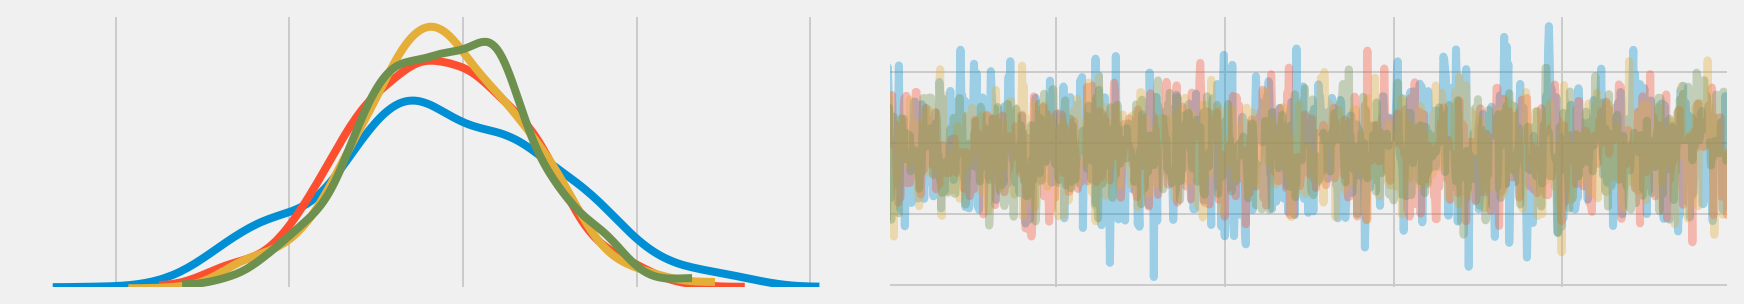

Model 8
----------
var = 1.8719434197280194
1.0016362181553269
1.0012622358109018
1.0014441513915144
1.01965379401201


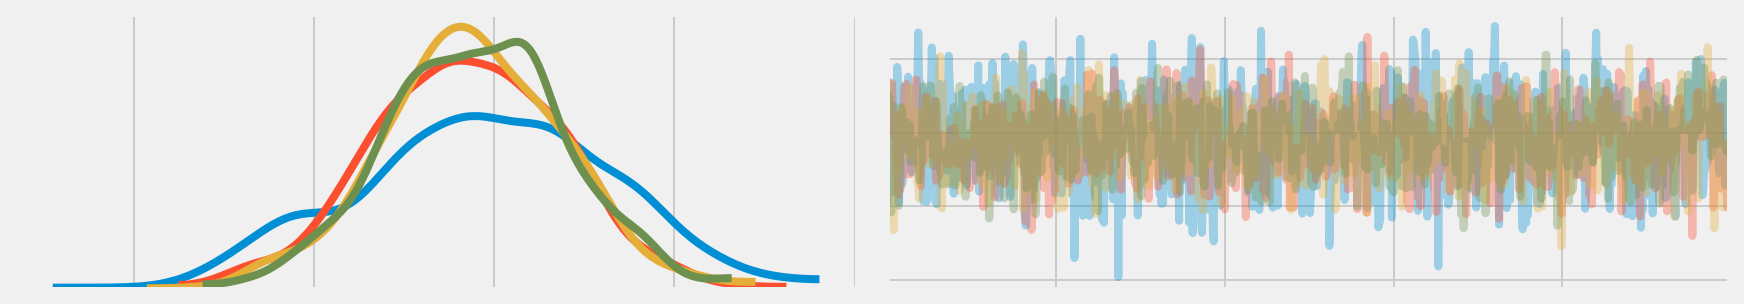

Model 9
----------
var = 2.0000000000000004
1.0003748447162633
1.000364945661931
1.0004349373203236
1.0241551406052156


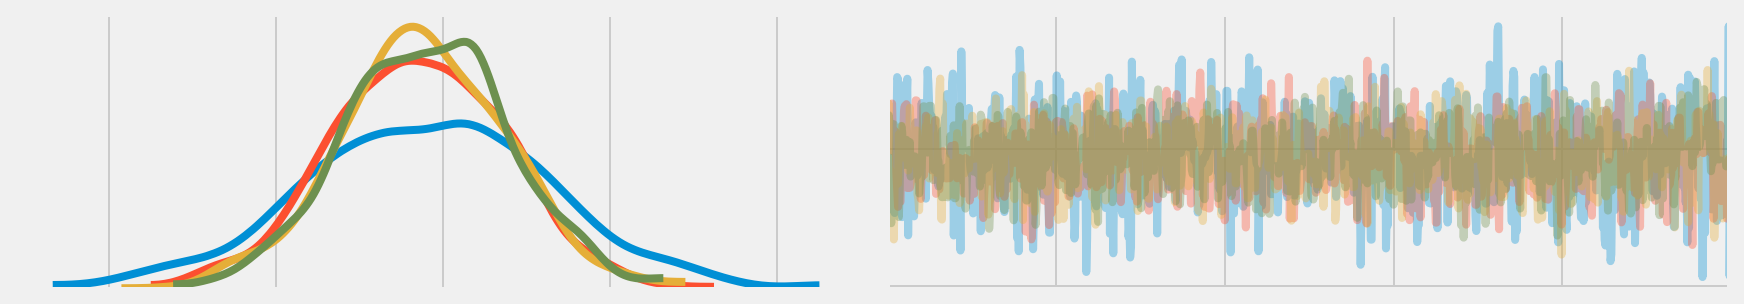

In [8]:
sigmas = np.linspace(1.0, np.sqrt(2), 10)
traces_fake = np.load("data/models.npy")
for i, (sigma, t) in enumerate(zip(sigmas, traces_fake)):
    # print stats
    rhat_stand = utils.rhat(t, split=False)
    rhat_split = utils.rhat(t, split=True)
    rhat_srank = utils.rank_rhat(t)
    rhat_sfold = utils.folded_split_rhat(t)
    
    print(f"Model {i}")
    print("----------")
    print(f"var = {sigma**2}")
    print(rhat_stand)
    print(rhat_split)
    print(rhat_srank)
    print(rhat_sfold)
    
    # show trace plot
    trace_dvar_dict = {params[0]:t}
    pm.traceplot(trace_dvar_dict)
    plt.show()

By eye, the models look to diverge around Model 4 $(\sigma^2 \approx 1.4)$, but analytically, the modified $\rhat$ implementations are able to pick out a convergence problem by Model 2 $(\sigma^2 \approx 1.2)$, while the standard implementation does not. In fact, the standard and split-$\rhat$ variants routinely fail in the larger variance cases, emphasizing the importance of using multiple convergence metrics.